<!--NOTEBOOK_HEADER-->
*This notebook contains material from [cbe30338-2021](https://jckantor.github.io/cbe30338-2021);
content is available [on Github](https://github.com/jckantor/cbe30338-2021.git).*


<!--NAVIGATION-->
< [5.1 Linear Production Model](https://jckantor.github.io/cbe30338-2021/05.01-Linear-Production-Model.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [5.3 Gasoline Blending](https://jckantor.github.io/cbe30338-2021/05.03-Gasoline-Blending.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 5.2 Linear Blending Problem

This notebook introduces simple material blending problems, and outlines a multi-step procedure for creating and solving models for these problems using CVXPY.

### 5.2.1 Learning Goals

* Linear Blending problems
    * Frequently encountered in material blending 
    * Models generally consist of linear mixing rules and mass/material balances
    * Decision variables are indexed by a set of raw materials


* Further practice with key elements of modeling for optimization
    * cvxpy.Variable(): Create instance of an optimization **decision variable**
    * cvxpy.Minimize()/cvxpy.Maximize(): Create instance of an **optimization objective**
    * cvxpy.Problem(): Create instance of an optimization problem with objective and **constraints**.
 
 
* Modeling and solving linear blending problems in CVXPY
    * Step 1. Coding problem data. Nested dictionaries or Pandas dataframes.
    * Step 2. Create index set. Use .keys() with nested dictionaries, or .index with Pandas dataframes.
    * Step 3. Create a dictionary of decision variables. Add any pertinent qualifiers or constraints for individual variables such as lower and upper bounds, non-negativity, variable names.
    * Step 4. Create an expression defining the problem objective.
    * Step 5. Create a one or more lists of problem constraints.
    * Step 6. Create the problem object from the objectives and constraints.
    * Step 7. Solve and display the solution.

## 5.2.1 Problem Statement (Jenchura, 2017)

A brewery receives an order for 100 gallons that is at least 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV and costs \\$0.32 per gallon to make, and beer B that is 3.7% ABV and costs \\$0.25 per gallon. Water (W) can also be used as a blending agent at a cost of \\$0.05 per gallon. Find the minimum cost blend of A, B, and W that meets the customer requirements.

## 5.2.2 Solving optimization problems with CVXPY

The blending problem described above is relatively simple, it can be solved in CVXPY using no more than `cp.Variable()`, `cp.Minimize()`, and `cp.Problem()` as demonstrated below.

In [1]:
import numpy as np
import cvxpy as cp

### 5.2.2.1 Step 1. Coding Problem Data as a Python Dictionary

The first step is to represent the problem data in a generic manner that could be extended to include additional blending components.  Here we use a dictionary of raw materials, each key denoting a unique blending agent. For each key there is a second level dictionary containing attributes of the blending component. This nested "dictionary of dictionaries" organization is a useful of organizing tabular data for optimization problems.

In [2]:
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}
print(data)

{'A': {'abv': 0.045, 'cost': 0.32}, 'B': {'abv': 0.037, 'cost': 0.25}, 'W': {'abv': 0.0, 'cost': 0.05}}


### 5.2.2.2 Step 2. Identifying index sets

The objectives and constraints encountered in optimization problems often include sums over a set of objects. In the case, we will need to create sums over the set of raw materials in the blending problem.

In [3]:
components = set(data.keys())
print(components)

{'A', 'W', 'B'}


### 5.2.2.3 Step 3. Create decision variables

In [4]:
x = {c: cp.Variable(nonneg=True) for c in components}
print(x)

{'A': Variable((), nonneg=True), 'W': Variable((), nonneg=True), 'B': Variable((), nonneg=True)}


### 5.2.2.4 Step 4. Objective Function

If we let subscript $c$ denote a blending component from the set of blending components $C$, and denote the volume of $c$ used in the blend as $x_c$, the cost of the blend is

\begin{align}
\mbox{cost} & = \sum_{c\in C} x_c P_c
\end{align}

where $P_c$ is the price per unit volume of $c$. Using the Python data dictionary defined above, the price $P_c$ is given by `data[c]['cost']`.

In [5]:
total_cost = sum([x[c]*data[c]["cost"] for c in components])
objective = cp.Minimize(total_cost)
print(objective)

minimize var0 @ 0.32 + var1 @ 0.05 + var2 @ 0.25


### 5.2.2.5 Step 5. Constraints

In [6]:
volume = 100
abv = 0.040

#### 5.2.2.5.1 Volume Constraint

The customer requirement is produce a total volume $V$. Assuming ideal solutions, the constraint is given by

\begin{align}
V &  = \sum_{c\in C} x_c
\end{align}

where $x_c$ denotes the volume of component $c$ used in the blend.

In [7]:
constraints = [volume == sum(x[c] for c in components)]

#### 5.2.2.5.2 Product Composition Constraint

The product composition is specified as requiring at least 4% alchohol by volume. Denoting the specification as $\bar{A}$, the constraint may be written as

\begin{align}
\bar{A} & \leq \frac{\sum_{c\in C}x_c A_c}{\sum_{c\in C} x_c}
\end{align}

where $A_c$ is the alcohol by volume for component $c$. As written, this is a nonlinear constraint. Multiplying both sides of the equation by the denominator yields a linear constraint

\begin{align}
\bar{A}\sum_{c\in C} x_c & \leq \sum_{c\in C}x_c A_c
\end{align}

A final form for this constraint can be given in either of two versions. In the first version we subtract the left-hand side from the right to give

\begin{align}
0 & \leq \sum_{c\in C}x_c \left(A_c - \bar{A}\right) & \mbox{ Version 1 of the linear blending constraint}
\end{align}

Alternatively, the summation on the left-hand side corresponds to total volume. Since that is known as part of the problem specification, the blending constraint could also be written as

\begin{align}
\bar{A}V & \leq \sum_{c\in C}x_c A_c  & \mbox{ Version 2 of the linear blending constraint}
\end{align}

Which should you use? Normally either will work well. The advantage of version 1 is that it is fully specified by a single product requirement $\bar{A}$, and doesn't require knowledge of the other product requirement $V$. This may be helpful in writing elegant Python code.

In [8]:
constraints.append(0 <= sum(x[c]*(data[c]['abv'] - abv) for c in components))

We can review the constraints by printing them out. If no name is specified for a decision variable when it is created, then cvxpy will assign a name beginiing with `var`. 

In [9]:
for constraint in constraints:
    print(constraint)

var0 + var1 + var2 == 100.0
0.0 <= var0 @ 0.0049999999999999975 + var1 @ -0.04 + var2 @ -0.0030000000000000027


<hr>

**Study Question:** Consult the CVXPY document for `cvxpy.Variable()`. Modify the code above to assign a name to each variable corresponding to the key for its entry in the data dictionary. Rerun the cells to see how the objective and constraints are printed.

<hr>

### 5.2.2.6 Step 6. Create CVXPY Problem object

An optimization problem consists of decision variables, and algebraic expressions that define an objective and a list of constranits. These are encapsulated into a CVXPY Problem.

In [10]:
problem = cp.Problem(objective, constraints)
problem.solve()

27.625000014836914

### 5.2.2.7 Step 7. Display solution

Following solution, the values of any CVXPY variable, expression, objective, or constraint can be accessed using the associated `value` property.

In [11]:
print(total_cost)

var0 @ 0.32 + var1 @ 0.05 + var2 @ 0.25


In [12]:
print(total_cost.value)

27.625000014836914


In [13]:
print(f"Minimum cost to produce {volume} gallons at ABV={abv}: ${total_cost.value:5.2f}")

Minimum cost to produce 100 gallons at ABV=0.04: $27.63


In [14]:
for c in sorted(components):
    print(f"{c}: {x[c].value:5.2f} gallons")

A: 37.50 gallons
B: 62.50 gallons
W:  0.00 gallons


## 5.2.3 Parametric Studies

An important use of optimization models is to investigate how operations depend on critical parameters. For example, for this blending problem we may be interested in questions like:

* How does the operating cost change with product alcohol content?
* What is the cost of producing one more gallon of product?
* What if the supply of a raw material is constrained?
* What if we produce two products rather than one?
* How much would be pay for raw materials with different specifications

### 5.2.3.1 Consolidating

To enable parametric studies, our first step is to consolidate the model into a function that accepts problem data and reports an optimal solution.

In [15]:
import numpy as np
import cvxpy as cp

def brew_blend(volume, abv, data):
    
    # create set of components
    components = set(data.keys())
    
    # create variables
    x = {c: cp.Variable(nonneg=True, name=c) for c in components}
    
    # create objective function
    total_cost = sum(x[c]*data[c]['cost'] for c in components)
    
    # create list of constraints
    constraints = [
        volume == sum(x[c] for c in components),
        0 == sum(x[c]*(data[c]['abv'] - abv) for c in components)
    ]
    
    # create and solve problem
    problem = cp.Problem(cp.Minimize(total_cost), constraints)
    problem.solve()
    
    # return results
    min_cost = problem.value
    optimal_blend = {c: x[c].value for c in components}
    return min_cost, optimal_blend


Minimum cost to produce 100 gallons at ABV=0.04 = $27.63
A: 37.50
B: 62.50
W:  0.00
{'A': 37.50000113605019, 'W': 2.4563236408825835e-07, 'B': 62.49999861831747}


Index(['A', 'W', 'B'], dtype='object', name='amount')

Demonstration

In [27]:
# problem data
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}

# product requirement
volume = 100
abv = 0.04

# optimal solution
min_cost, optimal_blend = brew_blend(volume, abv, data)

# display solutoin
print(f"Minimum cost to produce {volume} gallons at ABV={abv} = ${min_cost:5.2f}")
for c in sorted(optimal_blend.keys()):
    print(f"{c}: {optimal_blend[c]:5.2f}")

Minimum cost to produce 100 gallons at ABV=0.04 = $27.63
A: 37.50
B: 62.50
W:  0.00


The Pandas library has a function to convert dictionaries of data to DataFrames. This is a convenient way to display and visualize the data resulting from a complex optimization problem.

{'A': 37.50000113605019, 'W': 2.4563236408825835e-07, 'B': 62.49999861831747}


<AxesSubplot:>

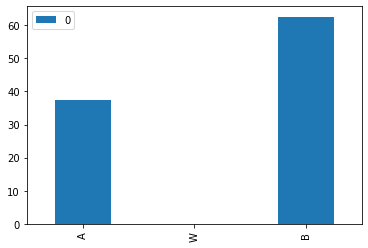

In [26]:
import pandas as pd

print(optimal_blend)
df = pd.DataFrame.from_dict(optimal_blend, orient="index")
df.plot(kind="bar")

### 5.2.3.2 Optimal blend as a function of product specification

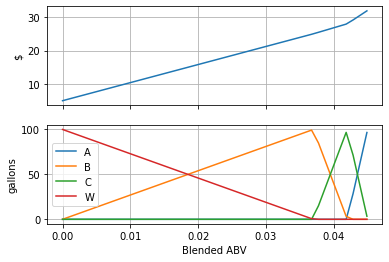

In [33]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}

# gather results for a range of abv values
abv = np.linspace(0, 0.05)
results = [brew_blend(volume, a, data) for a in abv]

fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(abv, [cost for cost, values in results])
ax[0].set_ylabel("$")
ax[0].grid(True)

for c in sorted(data.keys()):
    ax[1].plot(abv, [values[c] for cost, values in results], label=c)
ax[1].set_xlabel('Blended ABV')
ax[1].set_ylabel('gallons')
ax[1].legend()
ax[1].grid(True)

<hr>

**Study Question:** Suppose an additional raw material "C" becomes available with an abv of 4.2% at a cost of 28 cents per gallon. How does that change the optimal blend?

**Study Question:** Having decided to use "C" for the blended product, you learn that only 50 gallons of "C" are available. Modify the solution procedure to add this constraint, and investigate the implications for the optimal blend.

**Study Question:** An opportunity has developed to sell a second product with an abv of 3.8%. The first product is now labeled "X" with abv 4.0% and sells for \\$1.25 per gallon, and the second product is designated "Y" and sells for \\$1.10 per gallon. You've also learned that all of your raw materials are limited to 50 gallons. What should your production plan be to maximize profits?

<hr>

<!--NAVIGATION-->
< [5.1 Linear Production Model](https://jckantor.github.io/cbe30338-2021/05.01-Linear-Production-Model.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [5.3 Gasoline Blending](https://jckantor.github.io/cbe30338-2021/05.03-Gasoline-Blending.html) ><p><a href="https://colab.research.google.com/github/jckantor/cbe30338-2021/blob/master/docs/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/cbe30338-2021/05.02-Linear-Blending-Problem.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>